# Create a logistic regression model to predict several mutations from covariates

In [1]:
import os
import itertools
import warnings
import collections

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, grid_search
from sklearn.linear_model import SGDClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.special import logit

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Load Data

In [3]:
path = os.path.join('..', '..', 'download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

In [4]:
# Read sample information and create a covariate TSV
url = 'https://github.com/cognoma/cancer-data/raw/54140cf6addc48260c9723213c40b628d7c861da/data/covariates.tsv'
covariate_df = pd.read_table(url, index_col=0)
covariate_df.head(2)

,age_diagnosed,days_survived,days_recurrence_free,disease_adrenocortical cancer,disease_bladder urothelial carcinoma,disease_brain lower grade glioma,disease_breast invasive carcinoma,disease_cervical & endocervical cancer,disease_cholangiocarcinoma,disease_colon adenocarcinoma,...,organ_of_origin_Thymus,organ_of_origin_Thyroid Gland,organ_of_origin_Uterus,gender_Female,gender_Male,alive,dead,has_not_recurred,has_recurred,n_mutations_log1p
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,78.0,448.0,NaN,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,3.6889
TCGA-02-0055-01,62.0,76.0,NaN,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,3.5264


## Specify the type of classifier

In [5]:
param_grid = {
    'alpha': [10 ** x for x in range(-4, 2)],
    'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1],
}

clf = SGDClassifier(
    random_state=0,
    class_weight='balanced',
    loss='log',
    penalty='elasticnet'
)

# joblib is used to cross-validate in parallel by setting `n_jobs=-1` in GridSearchCV
# Supress joblib warning. See https://github.com/scikit-learn/scikit-learn/issues/6370
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')
clf_grid = grid_search.GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, scoring='roc_auc')
pipeline = make_pipeline(
    StandardScaler(),
    clf_grid
)

## Specify covariates and outcomes

In [6]:
def expand_grid(data_dict):
    """Create a dataframe from every combination of given values."""
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())

mutations = {
    '7157': 'TP53',   # tumor protein p53
    '7428': 'VHL',    # von Hippel-Lindau tumor suppressor
    '29126': 'CD274', # CD274 molecule
    '672': 'BRCA1',   # BRCA1, DNA repair associated
    '675': 'BRCA2',   # BRCA2, DNA repair associated
    '238': 'ALK',     # anaplastic lymphoma receptor tyrosine kinase
    '4221': 'MEN1',   # menin 1
    '5979': 'RET',    # ret proto-oncogene
}

options = collections.OrderedDict()

options['mutation'] = list(mutations)

binary_options = [
    'disease_covariate',
    'organ_covariate',
    'gender_covariate',
    'mutation_covariate',
    'survival_covariate'
]

for opt in binary_options:
    options[opt] = [0, 1]

option_df = expand_grid(options)
option_df['symbol'] = option_df.mutation.map(mutations)
option_df.head(2)

,mutation,disease_covariate,organ_covariate,gender_covariate,mutation_covariate,survival_covariate,symbol
0,238,0,0,0,0,0,ALK
1,238,0,0,0,0,1,ALK


In [7]:
covariate_to_columns = {
    'gender': covariate_df.columns[covariate_df.columns.str.startswith('gender')].tolist(),
    'disease': covariate_df.columns[covariate_df.columns.str.startswith('disease')].tolist(),
    'organ': covariate_df.columns[covariate_df.columns.str.contains('organ')].tolist(),
    'mutation': covariate_df.columns[covariate_df.columns.str.contains('n_mutations')].tolist(),
    'survival': ['alive', 'dead'],
}

## Compute performance

In [8]:
def get_aurocs(X, y, series):
    """
    Fit the classifier specified by series and add the cv, training, and testing AUROCs.
    series is a row of option_df, which specificies the which covariates and mutation
    status to use in the classifier.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
    series['positive_prevalence'] = np.mean(y)
    pipeline.fit(X=X_train, y=y_train)
    y_pred_train = pipeline.decision_function(X_train)
    y_pred_test = pipeline.decision_function(X_test)
    cv_score_df = grid_scores_to_df(clf_grid.grid_scores_)
    series['mean_cv_auroc'] = cv_score_df.score.max()
    series['training_auroc'] = roc_auc_score(y_train, y_pred_train)
    series['testing_auroc'] = roc_auc_score(y_test, y_pred_test)
    return series

def grid_scores_to_df(grid_scores):
    """
    Convert a sklearn.grid_search.GridSearchCV.grid_scores_ attribute to 
    a tidy pandas DataFrame where each row is a hyperparameter-fold combinatination.
    """
    rows = list()
    for grid_score in grid_scores:
        for fold, score in enumerate(grid_score.cv_validation_scores):
            row = grid_score.parameters.copy()
            row['fold'] = fold
            row['score'] = score
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

In [9]:
rows = list()
for i, series in option_df.iterrows():
    columns = list()
    for name, add_columns in covariate_to_columns.items():
        if series[name + '_covariate']:
            columns.extend(add_columns)
    if not columns:
        continue
    X = covariate_df[columns]
    y = Y[series.mutation]
    rows.append(get_aurocs(X, y, series))
auroc_df = pd.DataFrame(rows)
auroc_df.sort_values(['symbol', 'testing_auroc'], ascending=[True, False], inplace=True)

In [10]:
auroc_df.head()

,mutation,disease_covariate,organ_covariate,gender_covariate,mutation_covariate,survival_covariate,symbol,positive_prevalence,mean_cv_auroc,training_auroc,testing_auroc
19,238,1,0,0,1,1,ALK,0.018889,0.856415,0.827638,0.846732
22,238,1,0,1,1,0,ALK,0.018889,0.857618,0.829357,0.846334
23,238,1,0,1,1,1,ALK,0.018889,0.856177,0.829393,0.846135
30,238,1,1,1,1,0,ALK,0.018889,0.853851,0.829066,0.846035
31,238,1,1,1,1,1,ALK,0.018889,0.853125,0.828207,0.845637


In [11]:
auroc_df.to_csv('auroc.tsv', index=False, sep='\t', float_format='%.5g')

## Covariate performance by mutation

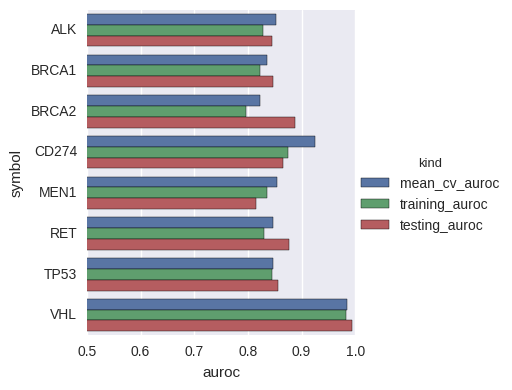

In [12]:
# Filter for models which include all covariates
plot_df = auroc_df[auroc_df[binary_options].all(axis='columns')]
plot_df = pd.melt(plot_df, id_vars='symbol', value_vars=['mean_cv_auroc', 'training_auroc', 'testing_auroc'], var_name='kind', value_name='auroc')
grid = sns.factorplot(y='symbol', x='auroc', hue='kind', data=plot_df, kind="bar")
xlimits = grid.ax.set_xlim(0.5, 1)